In [1]:
import csv
import thesis_tools
import numpy as np
import pandas as pd
from thesis_tools.utilities import get_f_star, calc_f
from astropy.io import fits
import astropy.units as u

import matplotlib.pyplot as plt
plt.style.use('sm')
import seaborn as sb
blue,amber,red,green=sb.xkcd_palette(['windows blue','amber','red','grass green'])

top_path='/Users/codydirks/PGCC/'
output_path='/Users/codydirks/Desktop/PGCC Paper/plots/'
def load_results(filename):
    gaia_filenames=[top_path+'tgas_data/TgasSource_000-000-0'+'{:02}'.format(i)+'.fits' for i in range(16)]
    pgcc_hdu=fits.open(top_path+'HFI_PCCS_GCC_R2.02.fits')
    pgcc_data=pgcc_hdu[1].data
    pgcc_hdu.close()
    sightline_pgcc_gaia_data=[]
    with open(filename,'r') as myfile:
        for line in myfile:
            dat=line.strip('|\n').split('|')
            sightline=dat[0]
            coords=dat[1].split(' ')
            ra=float(coords[0])*u.degree
            dec=float(coords[1])*u.degree
            pgcc=pgcc_data[int(dat[2])]
            if dat[3] != 'None':
                fl,idx=map(int,dat[3][1:-1].split(','))
                gfile=fits.open(gaia_filenames[fl])
                gaia_entry=gfile[1].data[idx]
                gfile.close()
            else:
                gaia_entry=None
                
            sightline_pgcc_gaia_data.append([sightline,(ra,dec),pgcc,gaia_entry])
    return sightline_pgcc_gaia_data


filename='sightline_pgcc_gaia_results.txt'
sightline_pgcc_data=load_results(filename)

sheffer_data=pd.read_csv('sheffer_co_h2.csv')
burgh_data=pd.read_csv('burgh_data.csv')
published_hs=pd.read_csv('clean_vizier_results.csv')

with open('primary_sightlines.csv','r') as csvfile:
    inp=csv.reader(csvfile)
    primary_sightlines=next(inp)
primary_sightlines.remove('HD148937')
sl_data=thesis_tools.load_data(primary_sightlines)
all_data=thesis_tools.load_results(sl_data)

# Gets elemental depletion parameters from Jenkins09 Table 4
epcols=['Ax','Bx','zx']
element_params=pd.read_csv('jenkins_table4.csv')
element_params[epcols]=element_params[epcols].apply(pd.to_numeric)
element_params['El']=pd.Series([x.strip() for x in element_params['El']])

/Users/codydirks/anaconda3/envs/astroconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


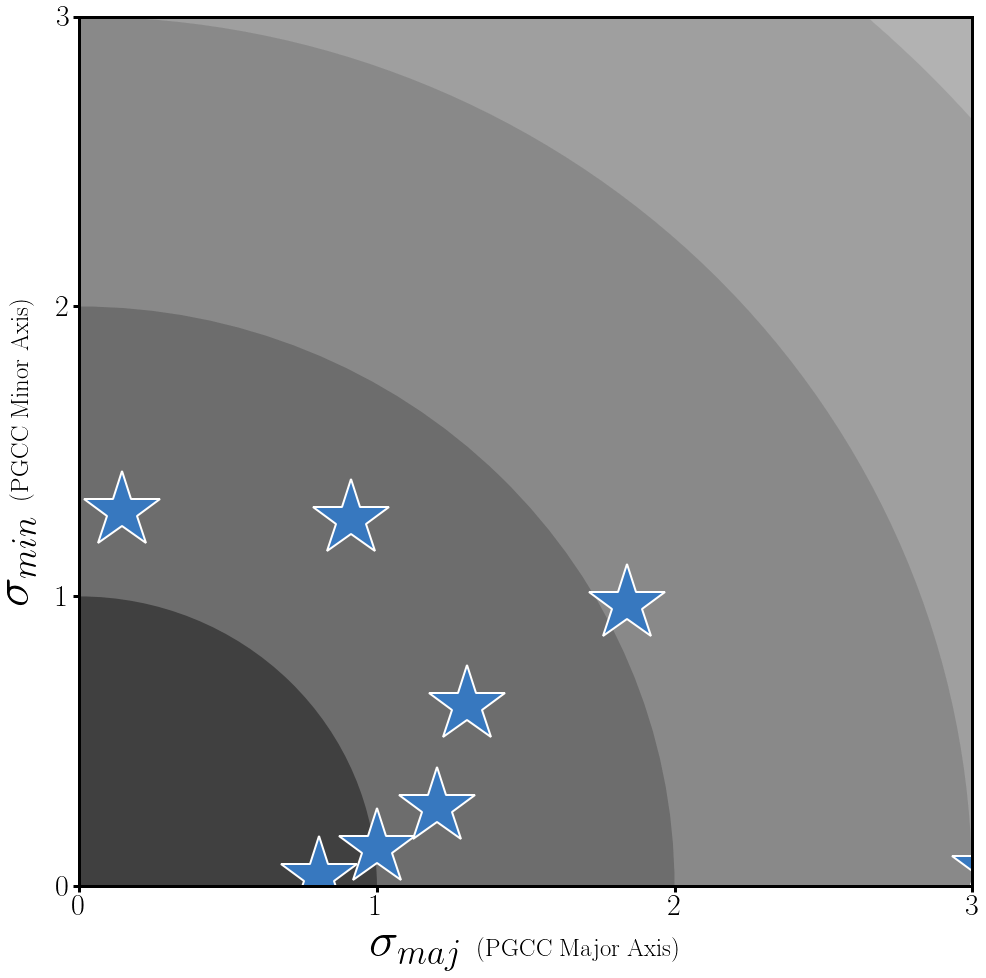

In [14]:
# Sightline 'bullseye'
import csv
import numpy as np
from astropy.io import fits
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline
plt.style.use('sm')

with open('primary_sightlines.csv','r') as csvfile:
    inp=csv.reader(csvfile)
    primary_sightlines=next(inp)
primary_sightlines.remove('HD148937')

import seaborn as sb
blue=sb.xkcd_palette(['windows blue'])[0]
amber=sb.xkcd_palette(['amber'])[0]
red=sb.xkcd_palette(['pale red'])[0]
top_path='/Users/codydirks/PGCC/'
def get_ang_sep(ra1,dec1,ra2,dec2):
    ra1_rad=ra1*np.pi/180.
    dec1_rad=dec1*np.pi/180.
    ra2_rad=ra2*np.pi/180.
    dec2_rad=dec2*np.pi/180.

    del_ra=ra2_rad-ra1_rad
    del_ras=np.sin(del_ra)
    del_rac=np.cos(del_ra)
    dec1s=np.sin(dec1_rad)
    dec2s=np.sin(dec2_rad)
    dec1c=np.cos(dec1_rad)
    dec2c=np.cos(dec2_rad)

    return (180./np.pi)*np.arctan(np.sqrt((dec2c**2)*(del_ras**2)+(dec1c*dec2s-dec1s*dec2c*del_rac)**2)/(dec1s*dec2s+dec1c*dec2c*del_rac))

def get_r_dist(pgcc,sightline_ra,sightline_dec):
    angle=pgcc['gau_position_angle']
    sin=np.sin(-angle)
    cos=np.cos(-angle)
    a=pgcc['gau_major_axis']/2.
    b=pgcc['gau_minor_axis']/2.
    gal=SkyCoord(ra=sightline_ra*u.degree,dec=sightline_dec*u.degree,frame='icrs').galactic
    del_l=60.*(gal.l.value-pgcc['glon'])
    del_b=60.*(gal.b.value-pgcc['glat'])
    return np.sqrt((((cos*del_l+sin*del_b)/a)**2+((sin*del_l-cos*del_b)/b)**2))

def load_results(filename):
    gaia_filenames=[top_path+'tgas_data/TgasSource_000-000-0'+'{:02}'.format(i)+'.fits' for i in range(16)]
    pgcc_hdu=fits.open(top_path+'HFI_PCCS_GCC_R2.02.fits')
    pgcc_data=pgcc_hdu[1].data
    pgcc_hdu.close()
    sightline_pgcc_gaia_data=[]
    with open(filename,'r') as myfile:
        for line in myfile:
            dat=line.strip('|\n').split('|')
            sightline=dat[0]
            coords=dat[1].split(' ')
            ra=float(coords[0])*u.degree
            dec=float(coords[1])*u.degree
            pgcc=pgcc_data[int(dat[2])]
            if dat[3] != 'None':
                fl,idx=map(int,dat[3][1:-1].split(','))
                gfile=fits.open(gaia_filenames[fl])
                gaia_entry=gfile[1].data[idx]
                gfile.close()
            else:
                gaia_entry=None
                
            sightline_pgcc_gaia_data.append([sightline,(ra,dec),pgcc,gaia_entry])
    return sightline_pgcc_gaia_data


fig=plt.figure(figsize=(16,16),facecolor='w')
subplt=plt.subplot(111)

for i in range(1,11):
    ell=Ellipse(xy=(0,0),width=2*i,
                height=2*i
                ,angle=0)
    ell.set_facecolor('k')
    ell.set_alpha(0.4/i)
    subplt.add_patch(ell)
    
filename='sightline_pgcc_gaia_results.txt'
sightline_pgcc_data=load_results(filename)

new_obs=[]#['HD236101','HD217943','HD147196','HD94414','HD334041']

for entry in [i for i in sightline_pgcc_data if i[0] in primary_sightlines+new_obs]:
    sl=entry[0]
    sl_ra,sl_dec=entry[1]
    pgcc=entry[2]
    r_dist=get_r_dist(pgcc,sl_ra.value,sl_dec.value)
    
    galcoord=SkyCoord(ra=sl_ra,dec=sl_dec).galactic
    del_l=60.*(galcoord.l.value-pgcc['glon'])
    del_b=60.*(galcoord.b.value-pgcc['glat'])
    theta=np.arctan(del_b/del_l)
    omega=-pgcc['gau_position_angle']
    phi=theta-omega
    sig_x=r_dist*np.cos(phi)
    sig_y=r_dist*np.sin(phi)
    if del_l<0:
        sig_x=-sig_x
        sig_y=-sig_y
    sig_x=abs(sig_x)
    sig_y=abs(sig_y)
    col=blue
    if sl in new_obs:
        col=red
    subplt.plot(sig_x,sig_y,marker='*',color=col,ms=80,mec='w',mew=2)
    

subplt.set_xticks(range(11))
subplt.set_yticks(range(11))
subplt.tick_params(axis='both',which='major',labelsize=30)
subplt.set_xlabel(r'$\displaystyle \sigma_{maj}$ \Huge (PGCC Major Axis)',fontsize=50,labelpad=20)
subplt.set_ylabel(r'$\displaystyle \sigma_{min}$ \Huge (PGCC Minor Axis)',fontsize=50,labelpad=20)
subplt.set_xlim(0,3)
subplt.set_ylim(0,3)

#inset_example=[i for i in sightline_pgcc_data if i[0]=='HD62542'][0]
#inset = inset_axes(subplt,
#                    width="35%",
#                    height="35%",
#                    loc=1,borderpad=1)

#inset_ra,inset_dec=inset_example[1]
#inset_pgcc=inset_example[2]
#inset_galcoord=SkyCoord(ra=inset_ra,dec=inset_dec).galactic
#inset.plot(10,5,
#           marker='*',color=blue,mec='w',ms=40,mew=2)

#for i in range(1,11):
#    ell=Ellipse(xy=(0,0),width=i*inset_pgcc['gau_major_axis'],
#                height=i*inset_pgcc['gau_minor_axis'],
#                angle=-(180./np.pi)*inset_pgcc['gau_position_angle'])
#    ell.set_facecolor('k')
#    ell.set_alpha(0.4/i)
    #inset.add_patch(ell)
    
#inset.plot([0,3.1],[0,7.9],linestyle='--',color='w',linewidth=3)
#inset.plot([0,3.8],[0,-1.5],linestyle='--',color='w',linewidth=3)
#inset.text(0.0,1.5,r'\boldmath$\sigma_{maj}$',rotation=180/np.pi*np.arctan(7.9/3.1),
#           color='w',fontsize=28,va='bottom',ha='center')
#inset.text(1.3,-0.2,r'\boldmath$\sigma_{min}$',rotation=180/np.pi*np.arctan(-1.5/3.8),
#           color='w',fontsize=28,va='top',ha='center')

#inset.set_xticklabels([])
#inset.set_yticklabels([])
#inset.set_xticks([])
#inset.set_yticks([])
#inset.set_xlabel('Relative Longitude',fontsize=30)
#inset.set_ylabel('Relative Latitude',fontsize=30)
#inset.set_xlim(-20,20)
#inset.set_ylim(-20,20)

#plt.savefig('/Users/codydirks/Desktop/bullseye1.pdf',box_inches='tight')

In [ ]:
#Fig 1: Sightline integrated C vs. CO, comparing mine to Burgh
import matplotlib.pyplot as plt
import seaborn as sb
blue=sb.xkcd_palette(['windows blue'])[0]
amber=sb.xkcd_palette(['amber'])[0]
red=sb.xkcd_palette(['pale red'])[0]

% matplotlib inline
plt.style.use('sm')

fig=plt.figure(1,figsize=(16,12),facecolor='w')
subplt=plt.subplot(111)

for sl,data in all_data.groupby('Sightline'):
    c_sum=np.log10((10**data[['C','C*','C**']]).sum().sum())
    co_sum=np.log10((10**data['CO']).sum())
    co_err=np.sqrt(((10**data['CO_err'])**2).sum())
    c_err=np.sqrt(((10**data[['C_err','C*_err','C**_err']].clip(0,14))**2).sum().sum())
    if (co_err/(10**co_sum)) >0.5:
        co_err=0.5*10**co_sum
    subplt.errorbar(10**c_sum,10**co_sum,yerr=co_err,xerr=c_err,
                    marker='o',color=blue,markersize=10,capsize=3,capthick=2,elinewidth=2)
    if sl=='HD220058':
        subplt.text(10**c_sum,10**co_sum,sl)



for idx,row in burgh_data.iterrows():
    if row['Sightline'] not in all_data['Sightline'].unique():
    # TODO: Add in upper limits
        cI=float(row['CI'])
        h2=float(row['H2'])
        cI_err=0.05 #dex
        if row['CO'].startswith('<'):
            co=float(row['CO'][1:])
            subplt.errorbar(10**cI,10**co,yerr=0.15*(10**co), xerr=cI_err*10**(cI),uplims=True,
                            color='k',marker='o',markersize=4,capsize=3,capthick=2,elinewidth=2,zorder=-1)
        else:
            co=float(row['CO'])
            co_err=float(row['CO_err'])
            subplt.errorbar(10**cI,10**co,yerr=co_err*10**(co),xerr=cI_err*10**(cI),
                            marker='o',color='k',markersize=7,capsize=3,capthick=2,elinewidth=2,zorder=-1)
            
            
tx=np.linspace(1e13,1e16,10)
for rat in (0.01,0.1,1,10):#,1e5,1e6):
    ty=rat*tx
    subplt.plot(tx,ty,'k--',linewidth=1,alpha=0.7)
    xspot=4.5e15
    t=subplt.text(xspot,rat*xspot,'10$^{'+str(int(np.log10(rat)))+'}$',
                fontsize=25,ha='center',va='center',rotation=0)
    t.set_bbox(dict(boxstyle='square,pad=0.3',facecolor='w', alpha=1, edgecolor='w'))

    
subplt.set_xlim(1e13,1e16)
subplt.set_yscale('log')
subplt.set_xscale('log')
    
subplt.set_ylim(1e12,1e17)

subplt.set_xlabel('N(C \\textsc{i}) (cm$^{-2}$)',fontsize=40)
subplt.set_ylabel('N(CO) (cm$^{-2}$)',fontsize=40)
subplt.tick_params(axis='both', which='major', labelsize=30)

subplt.text(0.01,0.98,'\\textbf{Non--PGCC (Burgh et al. 2010)}',
            color='k',fontsize=35,ha='left',va='top',transform=subplt.transAxes)
subplt.text(0.01,0.9,'\\textbf{PGCC (This Work)}',
            color=blue,fontsize=35,ha='left',va='top',transform=subplt.transAxes)

#plt.savefig('/Users/codydirks/Desktop/PGCC Paper/plots/burghcomparison.pdf',bbox_inches='tight')

In [ ]:
#Comparing sightline-integrated to components
fig=plt.figure(1,figsize=(16,12),facecolor='w')
subplt=plt.subplot(111)

fitx=np.empty(0)
fity=np.empty(0)
for sl,data in all_data.groupby('Sightline'):
    c_sum=np.log10((10**data[['C','C*','C**']]).sum().sum())
    co_sum=np.log10((10**data['CO']).sum())
    co_err=np.sqrt(((10**data['CO_err'])**2).sum())
    c_err=np.sqrt(((10**data[['C_err','C*_err','C**_err']].clip(0,14))**2).sum().sum())
    if (co_err/(10**co_sum)) >0.5:
        co_err=0.5*10**co_sum
    if len(data)>1:
        subplt.errorbar(10**c_sum,10**co_sum,yerr=co_err,xerr=c_err,
                        marker='o',color='k',markersize=10,capsize=3,capthick=2,elinewidth=2,zorder=-1)
    
    for idx,row in data.sort_values('CO',ascending=False).iterrows():
        c=np.log10((10**row[['C','C*','C**']]).sum())
        c_err=0.434*np.sum([10**row[col+'_err'] for col in ('C','C*','C**')])/10**c
        co=row['CO']
        if co<10:
            subplt.errorbar(10**c,10**row['CO_err'],yerr=0.15*10**row['CO_err'],uplims=True,
                            color=blue,marker='o',markersize=2)
        else:
            co_err=0.434*(10**(row['CO_err']-co))
            subplt.errorbar(10**c,10**co,xerr=c_err*(10**c),yerr=co_err*(10**co),
                             marker='o',color=blue,markersize=10,capsize=3,capthick=2,elinewidth=2)
        
        
for idx,row in burgh_data.iterrows():
    if row['Sightline'] not in all_data['Sightline'].unique():
    # TODO: Add in upper limits
        cI=float(row['CI'])
        h2=float(row['H2'])
        cI_err=0.05 #dex
        if row['CO'].startswith('<'):
            co=float(row['CO'][1:])
            subplt.errorbar(10**cI,10**co,yerr=0.15*(10**co), xerr=cI_err*10**(cI),uplims=True,
                            color='k',marker='o',markersize=4,capsize=3,capthick=2,elinewidth=2,zorder=-1)
        else:
            co=float(row['CO'])
            co_err=float(row['CO_err'])
            subplt.errorbar(10**cI,10**co,yerr=co_err*10**(co),xerr=cI_err*10**(cI),
                            marker='o',color='k',markersize=7,capsize=3,capthick=2,elinewidth=2,zorder=-1)

tx=np.linspace(13,16,30)
for rat in (-2,-1,0,1):
    ty=tx+rat
    subplt.plot(10**tx,10**ty,'k--',linewidth=1)
    subplt.text(10**(tx[-4]),1.07*10**(ty[-4]),str(10**rat),fontsize=30,ha='left',va='bottom',rotation=24.5)
        
subplt.set_xlim(1e13,1e16)
subplt.set_ylim(5e11,1.3e17)
subplt.set_yscale('log')
subplt.set_xscale('log')
subplt.set_ylabel('N(CO) (cm$^{-2}$)',fontsize=40,labelpad=20)
subplt.set_xlabel(' N(C \\textsc{i}) (cm$^{-2}$)',fontsize=40)
subplt.tick_params(axis='both', which='major', labelsize=30)
subplt.text(0.98,0.2,'\\textbf{Components}',color=blue,fontsize=30,horizontalalignment='right',transform=subplt.transAxes)
subplt.text(0.98,0.15,'\\textbf{(This Work)}',color=blue,fontsize=30,horizontalalignment='right',transform=subplt.transAxes)
subplt.text(0.98,0.08,'\\textbf{Sightline -- Integrated}',color='k',fontsize=30,horizontalalignment='right',transform=subplt.transAxes)
subplt.text(0.98,0.03,'\\textbf{(This Work + Burgh et al. 2010)}',color='k',fontsize=30,horizontalalignment='right',transform=subplt.transAxes)

#plt.savefig('/Users/codydirks/Desktop/PGCC Paper/plots/components.pdf')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sb
blue=sb.xkcd_palette(['windows blue'])[0]
amber=sb.xkcd_palette(['amber'])[0]
red=sb.xkcd_palette(['pale red'])[0]
green=sb.xkcd_palette(['dusty green'])[0]
plt.style.use('sm')
#fig=plt.figure(1,figsize=(16,12),facecolor='w')
fig,(subplt1,subplt2,subplt3)=plt.subplots(ncols=1,nrows=3,sharex=True,figsize=(16,12))
plt.subplots_adjust(hspace=0.08)

def hist_plotter(subplt,data,num_bin,normed=False,xlog=True,ylog=False,col='k',label='',factor=1):
    mini,maxi=[min(data),max(data)]
    if xlog:
        mini,maxi=np.log10([mini,maxi])
    bin_lims = np.linspace(mini,maxi,num_bin+1)
    if xlog:
        bin_lims=10**bin_lims
    bin_centers = 0.5*(bin_lims[:-1]+bin_lims[1:])
    bin_widths = bin_lims[1:]-bin_lims[:-1]
    hist, _ = np.histogram(data, bins=bin_lims,normed=normed)
    subplt.bar(bin_centers, hist*factor, width = bin_widths, align = 'center',
               color=col,alpha=0.1,zorder=-1)
    #Trickery to make sure step lines extend to the edges of the histogram bars
    x=np.concatenate([np.array([0.99*bin_lims[0]]),bin_lims])
    y=np.concatenate([np.array([0]),hist,np.array([0])])
    subplt.step(x, y*factor, where='post',
               color=col,alpha=1,zorder=-1,label=label)
    if xlog:
        subplt.set_xscale('log')
    if ylog:
        subplt.set_yscale('log')

uv_h2s=[]
for sl,data in all_data.groupby('Sightline'):
    c_sum=np.log10((10**data[['C','C*','C**']]).sum().sum())

    co_sum=np.log10((10**data['CO']).sum())
    
    published_h2s=published_hs[published_hs['Name']==sl]['N(H2)']
    if len(published_h2s)>0:
        h2_sum=np.log10(published_h2s.iloc[-1])
    else:
        co_h2_ratio=((co_sum-c_sum)-5.4674)/0.949756
        h2_sum=co_sum-co_h2_ratio
    uv_h2s.append(h2_sum)
    
uv_h2s=np.log10(np.array([i[2]['NH2'] for i in sightline_pgcc_data if i[0] in primary_sightlines and i[2]['NH2']>0]))

uv_h2s=10**(np.array(uv_h2s))
pgcc_hdu=fits.open('/Users/codydirks/PGCC/HFI_PCCS_GCC_R2.02.fits')
pgcc_data=pgcc_hdu[1].data
pgcc_hdu.close()
cleaned_data=np.log10(pgcc_data[np.where(pgcc_data['NH2']>0)]['NH2'])
yuan_data=pd.read_csv('/Users/codydirks/Downloads/yuan.csv')
yuan_h2=1e21*yuan_data['NH2']
wu_data=pd.read_csv('/Users/codydirks/Downloads/wu.csv')
wu_h2=1e21*wu_data['NH2']

num_bin = 20
bin_lims = 10**(np.linspace(min(cleaned_data),max(cleaned_data),num_bin+1))
bin_centers = 0.5*(bin_lims[:-1]+bin_lims[1:])
bin_widths = bin_lims[1:]-bin_lims[:-1]

normed=False

# All PGCC Histogram
hist_plotter(subplt1,10**cleaned_data,20,label='All PGCCs')
leg1=subplt1.legend(fontsize=20,loc=2)

#This Work histogram
hist_plotter(subplt3,uv_h2s,10,col=blue,label='This Work')
leg3=subplt3.legend(fontsize=20,loc=2)


# Other studies histogram
hist_plotter(subplt2,wu_h2[wu_h2>0],20,col=green,label='Wu et al. (2012)')
hist_plotter(subplt2,yuan_h2[np.isfinite(yuan_h2)],20,col=red,label='Yuan et al. (2016) $\\times$ 5',factor=5)

data_to_sample=pgcc_data[(pgcc_data['dist']>0) &
                         (0<pgcc_data['glon']) & (pgcc_data['glon']<248) &
                         (pgcc_data['NH2']>2e20) &
                         (pgcc_data['XFLAG_LMC']==-1) & (pgcc_data['XFLAG_SMC']==-1)]

#hist_plotter(subplt2,data_to_sample[idxs]['NH2'],20,col=amber,label='Liu et al. (2018) (Approx)')
leg2=subplt2.legend(fontsize=20,loc=2)

for leg in (leg1,leg2,leg3):
    for line in leg.get_lines():
        line.set_linewidth(10)
        line.set_alpha(1.0)
    vp = leg._legend_box._children[-1]._children[0] 
    #for c in vp._children: 
    #    c._children.reverse() 
    #vp.align="right" 
subplt3.set_xscale('log')
subplt3.set_xlim(6e18,1.1e23)
subplt3.set_xlabel('N(H$_2$) (cm$^{-2}$)',fontsize=35,labelpad=15)

for subplt in (subplt1,subplt2,subplt3):
    #subplt.set_yscale('log')
    subplt.set_ylim(0,1.1*subplt.get_ylim()[1])
    if normed:
        subplt.set_yticks([])
        
subplt1.tick_params(axis='y',labelsize=20)
subplt2.tick_params(axis='y',labelsize=20)
subplt3.tick_params(axis='y',labelsize=20)
subplt3.tick_params(axis='x',labelsize=30)
subplt3.set_yticks([0,2,4,6,8,10])
        
if normed:
    subplt2.set_ylabel('Normalized Count',fontsize=40)
else:
    subplt2.set_ylabel('Count',fontsize=40)
plt.savefig('/Users/codydirks/Desktop/PGCC Paper/plots/normed_prev_pgcc_studies.pdf',bbox_inches='tight')

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('sm')
import seaborn as sb
blue=sb.xkcd_palette(['windows blue'])[0]
amber=sb.xkcd_palette(['amber'])[0]
red=sb.xkcd_palette(['pale red'])[0]

fig,(subplt1,subplt2)=plt.subplots(ncols=1,nrows=2,sharex=True,figsize=(16,12),facecolor='w')
#subplt2r=subplt2.twinx()
plt.subplots_adjust(hspace=0.1)

co_thres=1e15
    
for sl,data in all_data.groupby('Sightline'):
    row=data.sort_values('CO',ascending=False).iloc[0]
    co=row['CO']
    co_err=row['CO_err']
    if sl=='HD23180':
        co_err=14.1
    c_sum=np.log10((10**row[['C','C*','C**']]).sum())
    c_sum_err=np.log10(np.sqrt(((10**row[['C_err','C*_err','C**_err']])**2).sum()))
    
    published_h2s=published_hs[published_hs['Name']==sl]['N(H2)']
    if len(published_h2s)>0 and len(data)==1:
        h2=np.log10(published_h2s.iloc[-1])
        co_h2_ratio=row['CO']-h2
    else:
        co_h2_ratio=((row['CO']-c_sum)-5.4674)/0.949756
        h2=row['CO']-co_h2_ratio
    fh2=2*(10**h2)/(10**row['H_tot'])
    neutral_c_ratio=(10**(row['CO'])+(10**c_sum))/10**(row['H_tot'])
    co_c_ratio=10**(row['CO']-c_sum)

    col=red
    if row['CO']>np.log10(co_thres):
        col=blue
    #subplt1.plot(row['R_dist'],10**co,marker='o',color=col,markersize=50*np.sqrt(10**(co_err-co))+5)
    subplt1.errorbar(row['R_dist'],10**co,yerr=3*10**co_err,marker='o',color=col,markersize=10)
    
    co_c_ratio_err=co_c_ratio*np.sqrt((10**(row['CO_err']-row['CO']))**2+(10**(c_sum_err-c_sum))**2)
    #subplt2.plot(row['R_dist'],co_c_ratio,marker='o',color=col,markersize=50*np.sqrt(co_c_ratio_err/co_c_ratio)+5)
    subplt2.errorbar(row['R_dist'],co_c_ratio,yerr=co_c_ratio_err,marker='o',color=col,markersize=10)
    #print(sl,row['R_dist'],co,co_err,co_c_ratio_err)



#fig.suptitle('Strongest Component',fontsize=35)
subplt2.set_xlim(0,10)
subplt1.set_ylim(2e12,5e16)
#subplt2.set_ylim(8e-7,3e-5)
subplt2.set_ylim(-0.5,13)
#subplt2.set_yticks([0,2,4,6,8,10,12])
#subplt4.set_ylim(0.000005,0.0001)
subplt1.set_yscale('log')
#subplt2.set_yscale('log')

subplt1.axhline(1e15,linestyle='--',color='k')
#subplt2.axhline(0,linestyle='--',color='k')

subplt1.tick_params(axis='both',labelsize=30)
subplt2.tick_params(axis='both',labelsize=30)
subplt2.set_xlabel('Distance ($\sigma$)',fontsize=40)
subplt1.set_ylabel('N(CO) (cm$^{-2}$)',fontsize=35,labelpad=15)
subplt2.set_ylabel(r'N(CO)/N(C~\textsc{i})',fontsize=35,labelpad=25)

subplt2.set_yticks([0,2,4,6,8,10,12])
#subplt2r.set_ylim(-0.1e-5,2.6e-5)
#subplt2r.ticklabel_format(style='sci',axis='y',scilimits=(-4,-7))
#subplt2r.tick_params(axis='y',labelsize=30)
#subplt2r.yaxis.offsetText.set_visible(False)
#subplt2r.set_ylabel(r'N(CO)/N(H$_2$)$\times10^{-5}$',fontsize=35,labelpad=45,rotation=270);
#subplt2r.set_yscale('log')
#plt.savefig('/Users/codydirks/Desktop/distance_dependence3.pdf',bbox_inches='tight')

In [ ]:
# Derive H2 from CO/C
from scipy.stats import linregress
fig=plt.figure(figsize=(16,12),facecolor='w')
subplt=plt.subplot(111)

# Plot H2 and CO for all components with detected Cl I (which traces H2)
mine_x,mine_y,mine_x_err,mine_y_err=[],[],[],[]
single_x,single_y,single_x_err,single_y_err=[],[],[],[]
for sl,data in all_data.groupby('Sightline'):
    c_sum=np.log10((10**data[['C','C*','C**']]).sum().sum())
    co_sum=np.log10((10**data['CO']).sum())
    published_h2s=published_hs[published_hs['Name']==sl][['N(H2)','E_N(H2)']]
    if len(published_h2s.dropna())>0:
        h2_sum,h2_sum_err=np.log10(published_h2s.iloc[-1])
        if np.isnan(h2_sum_err) or sl=='HD62542':
            h2_sum_err=np.log10(0.2*10**h2_sum)
        co_c_ratio=co_sum-c_sum
        co_h2_ratio=co_sum-h2_sum
        
        co_sum_err=np.sqrt(((10**data['CO_err'])**2).sum())
        c_sum_err=np.sqrt(((10**data[['C_err','C*_err','C**_err']])**2).sum().sum())
        if(c_sum_err/10**c_sum)>0.2:
            c_sum_err=0.2*10**c_sum
        co_c_err=np.sqrt((co_sum_err/10**co_sum)**2+(c_sum_err/10**c_sum)**2)
        co_h2_err=0.434*np.sqrt((co_sum_err/10**co_sum)**2+(10**h2_sum_err/10**h2_sum)**2)
        if len(data)==1:
            single_x.append(co_h2_ratio)
            single_y.append(co_c_ratio)
            single_x_err.append(co_h2_err)
            single_y_err.append(co_c_err)
        else:
            mine_x.append(co_h2_ratio)
            mine_y.append(co_c_ratio)
            mine_x_err.append(co_h2_err)
            mine_y_err.append(co_c_err)
        #subplt.plot(co_h2_ratio,co_c_ratio,marker='o',color=blue,markersize=15,zorder=1,label='This Work')
        
burgh_x,burgh_y,burgh_x_err,burgh_y_err=[],[],[],[]

for idx,row in burgh_data.iterrows():
    if row['CO'].startswith('<')==False:
        co_c_ratio=float(row['CO'])-row['CI']
        co_h2_ratio=float(row['CO'])-row['H2']
        co_c_err=float(row['Err'])
        co_h2_err=0.434*np.sqrt(row['CO_err']**2+row['H2_err']**2)
        burgh_x.append(co_h2_ratio)
        burgh_y.append(co_c_ratio)
        burgh_y_err.append(0.434*co_c_err/10**co_c_ratio)
        burgh_x_err.append(co_h2_err)
subplt.errorbar(mine_x,mine_y,xerr=mine_x_err,yerr=mine_y_err,
            linestyle='None',marker='o',color=blue,markersize=15,label='This Work',zorder=1)
subplt.errorbar(single_x,single_y,xerr=single_x_err,yerr=single_y_err,
            linestyle='None',marker='s',color=blue,markersize=15,label='This Work (Single Component)',zorder=1)
subplt.errorbar(burgh_x,burgh_y,xerr=burgh_x_err,yerr=burgh_y_err,
                linestyle='None',marker='o',color='k',markersize=15,label='Burgh et al. (2010)',zorder=0)


fitx=np.array(mine_x+burgh_x)
fity=np.array(mine_y+burgh_y)
fit=linregress(x=fitx,y=fity)
tx=np.linspace(-7,-4,10)
subplt.plot(tx,fit.slope*tx+fit.intercept,linestyle='--',color=red,zorder=-1)
#            ,label='$[\\frac{ \\mathrm{N(CO)} }{ \\mathrm{N(C\;{\\Huge \\textsc{i})}} }] =' \
#            ' 0.95\,[\\frac{ \\mathrm{N(CO)} }{ \\mathrm{N(H_2)} }] + 5.4674$')
    
    
subplt.text(-3.9,-1.55,
            '$[\\frac{ \\mathrm{N(CO)} }{ \\mathrm{N(C\;\;\,)} }] =' \
            ' 0.95\,[\\frac{ \\mathrm{N(CO)} }{ \\mathrm{N(H_2)} }] + 5.4674$',
            fontsize=45,ha='right',va='bottom')
subplt.text(-5.615,-1.515,
            '\\textsc{i}',
            fontsize=35,ha='right',va='bottom')
subplt.axhline(-1.33,0.31,0.37,linestyle='--',color=red,lw=4)

plt.tick_params(axis='both',which='major',labelsize=30)

handles,labels=subplt.get_legend_handles_labels()
subplt.legend(handles[::-1], labels[::-1],loc=2,fontsize=35,borderpad=0.0,handletextpad=0,frameon=False)

subplt.set_ylabel('Log$_{10}$ N(CO)/N(C \\textsc{i})',fontsize=40)
subplt.set_xlabel('Log$_{10}$ N(CO)/N(H$_2$)',fontsize=40,labelpad=15)
plt.savefig(output_path+'h2_method.pdf',bbox_inches='tight')

In [ ]:
import pickle as pkl
import matplotlib as mpl

with open('gong_results.pkl','rb') as fl:
    theor_results=pkl.load(fl)
    
idxs=[0,1,2,-1]
theor_results=[theor_results[i] for i in idxs]
fig,subplts=plt.subplots(ncols=len(theor_results),nrows=1,sharey=True,figsize=(24,12),facecolor='w')
plt.subplots_adjust(wspace=0)
for subplt,(n,[(s1,(h,c)),(s2,(_,co)),(s3,(_,cii)),(s4,(_,h2))]) in zip(subplts,theor_results):
    c=c-1.8
    c_sum=np.log10(10**c+10**co+10**cii)
    co_frac=10**(co-c_sum)
    c_frac=10**(c-c_sum)
    cii_frac=10**(cii-c_sum)
    subplt.plot(10**h,co_frac,linestyle='-',color=blue,linewidth=4)
    subplt.plot(10**h,c_frac,linestyle='-',color=red,linewidth=4)
    subplt.plot(10**h,cii_frac,linestyle='-',color='k',linewidth=4)
    #idx=np.where(co<13)[0][-1]
    #subplt.axhline(1e13, 0,0.34,color='k',linestyle='--',linewidth=1)
    #subplt.axvline(10**h[idx+1],color='k',linestyle='--',linewidth=1)
    #print(n,10**h[idx+1])
    subplt.set_xscale('log')
    subplt.set_yscale('log')
    subplt.text(1e22,1.7e-6,'n = '+str(n)+' cm$^{-3}$',ha='right',va='bottom',fontsize=30)
    subplt.tick_params(axis='both',which='major',labelsize=30)
subplts[0].set_ylabel('Fraction',fontsize=30)
fig.text(0.5,0.05, 'N(H$_{tot}$)',fontsize=30)

patches = [mpl.lines.Line2D([],[],color=col, label=text,linestyle='-',linewidth=10) 
           for col,text in (('k','C~\\textsc{ii}'),(red,'C~\\textsc{i}'),(blue,'CO'))]

leg=plt.legend(handles=patches,ncol=3,loc='lower right',bbox_to_anchor=(1,1),fontsize=30)
for line in leg.get_lines():
    line.set_linewidth(7)
#subplt.set_xlabel('N(H$_{tot}$)')
#subplt.set_ylabel('N')

In [ ]:
#Jenkins carbon pressure plot w/ co-bright and -dark

# Compiles the Jenkins f1,f2 data
jenkins_c_data=pd.read_csv('jenkins_c_table.txt',header=23)
jenkins_c_data['C*']=np.log10(jenkins_c_data['f1']*jenkins_c_data['N(CIt)'])
jenkins_c_data['C**']=np.log10(jenkins_c_data['f2']*jenkins_c_data['N(CIt)'])
jenkins_c_data['C']=np.log10(jenkins_c_data['N(CIt)']-(10**jenkins_c_data['C*']+10**jenkins_c_data['C**']))
jenkins_c_data['N(CIt)']=np.log10(jenkins_c_data['N(CIt)'])
jenkins_c_data=jenkins_c_data.rename(index=str, columns={"N(CIt)": "Ctot", "Name": "Sightline", "Vel":"Velocity"})
jenkins_c_data=jenkins_c_data[['Sightline','Velocity','C','C*','C**','Ctot','f1','e_f1','f2','e_f2']]

pts_100k=[(0.0,0.025,0.003),
     (0.5,0.043,0.005),
    (1.0,0.092,0.0135),
    (1.1,0.109,0.016),
    (1.2,0.1285,0.0195),
    (1.3,0.151,0.024),
    (1.4,0.178,0.0295),
    (1.5,0.2075,0.036),
    (1.6,0.24,0.0448),
    (1.7,0.274,0.0547),
    (1.8,0.309,0.0668),
    (1.9,0.3436,0.0815),
    (2.0,0.376,0.0977),
    (2.1,0.4055,0.117),
    (2.2,0.43,0.1384),
    (2.3,0.4492,0.1617),
    (2.4,0.4623,0.1868),
    (2.5,0.47,0.212),
    (2.6,0.473,0.238),
    (2.7,0.4715,0.2635),
    (2.8,0.4673,0.2877),
    (2.9,0.461,0.31),
    (3.0,0.4535,0.3305),
    (3.1,0.4455,0.349),
    (3.2,0.438,0.364),
    (3.3,0.4307,0.378),
    (3.4,0.4245,0.39),
    (3.5,0.419,0.399),
    (3.6,0.414,0.4073),
    (3.7,0.4097,0.414),
    (3.8,0.4065,0.4195),
    (4.0,0.4015,0.4275),
    (5.0,0.393,0.44)]

fig=plt.figure(figsize=(16,12),facecolor='w')
subplt=plt.subplot(111)

x = jenkins_c_data['f1']
y = jenkins_c_data['f2']
xmin, xmax = -0.02, 0.52
ymin, ymax = -0.04, 0.6

#subplt.plot(x,y,'ko',markersize=3,zorder=1,alpha=0.3,label='Jenkins \\& Tripp (2011)')
subplt.set_xlim(xmin,xmax)
subplt.set_ylim(ymin,ymax)

for pts in [pts_100k]:
    n,x,y=list(zip(*pts))
    subplt.plot(x,y,'ko',linestyle='-',label='T = 100K',markersize=10)

#props = dict(boxstyle='round,pad=0.1', facecolor='w', alpha=0.5)
for pt in pts:
    n,x,y=pt
    if n%1==0:
        subplt.plot(x,y,'ko',markersize=20)
        ha='left'
        va='bottom'
        yshift=0.01
        if n<3:
            ha='center'
            va='top'
            yshift=-0.01
        subplt.text(x,y+yshift,'\\textbf{{{:}}}'.format(int(n)),fontsize=30,ha=ha,va=va)
    
brights,bright_errs=[],[]
darks,dark_errs=[],[]
for sl,data in all_data.groupby('Sightline'):
    row=data.sort_values('CO',ascending=False).iloc[0]
    c_tot=(10.**row[['C','C*','C**']]).sum()
    c_tot_err=np.sqrt(((10.**row[['C_err','C*_err','C**_err']])**2).sum())
    f1=(10**row['C*'])/c_tot
    f2=(10**row['C**'])/c_tot
    f1_err=f1*np.sqrt((10**(row['C*_err']-row['C*']))**2+(c_tot_err/c_tot)**2)
    f2_err=f2*np.sqrt((10**(row['C**_err']-row['C**']))**2+(c_tot_err/c_tot)**2)
    if row['CO']>15:
        brights.append((f1,f2))
        bright_errs.append((f1_err,f2_err))
    else:
        darks.append((f1,f2))
        dark_errs.append((f1_err,f2_err))

x,y=list(zip(*brights))
xerr,yerr=list(zip(*bright_errs))
subplt.errorbar(x,y,xerr=xerr,yerr=yerr,
                color=blue,linestyle='None',marker='o',markersize=15,zorder=3,label='CO -- Bright')

#subplt.plot(np.mean(x),np.mean(y),marker='o',color='k',markersize=20,zorder=4)
#subplt.plot(np.mean(x),np.mean(y),marker='o',color=blue,markersize=15,zorder=5)

x,y=list(zip(*darks))
xerr,yerr=list(zip(*dark_errs))
subplt.errorbar(x,y,xerr=xerr,yerr=yerr,
                color=red,linestyle='None',marker='o',markersize=15,zorder=2, label='CO -- Dark')

#subplt.plot(np.mean(x),np.mean(y),marker='o',color='k',markersize=20,zorder=3)
#subplt.plot(np.mean(x),np.mean(y),marker='o',color=red,markersize=15,zorder=4)

f1_num,f1_dem,f2_num,f2_dem=0.,0.,0.,0.
for i in range(len(brights)):
    f1,f2=brights[i]
    f1_err,f2_err=bright_errs[i]
    w_f1=1./(f1_err**2)
    w_f2=1./(f2_err**2)
    f1_num=f1_num+(w_f1*f1)
    f1_dem=f1_dem+w_f1
    f2_num=f2_num+(w_f2*f2)
    f2_dem=f2_dem+(w_f2)
f1_weighted_mean=f1_num/f1_dem
f2_weighted_mean=f2_num/f2_dem
f1_err=np.sqrt(1./f1_dem)
f2_err=np.sqrt(1./f2_dem)
print(f1_weighted_mean,f2_weighted_mean)
print(f1_err,f2_err)
subplt.errorbar(f1_weighted_mean,f2_weighted_mean,xerr=f1_err,yerr=f2_err,
                marker='*',color='k',mec='k',markersize=35,zorder=3)
subplt.plot(f1_weighted_mean,f2_weighted_mean,marker='*',color=blue,mec=blue,markersize=20,zorder=4)

f1_num,f1_dem,f2_num,f2_dem=0.,0.,0.,0.
for i in range(len(darks)):
    f1,f2=darks[i]
    f1_err,f2_err=dark_errs[i]
    w_f1=1./(f1_err**2)
    w_f2=1./(f2_err**2)
    f1_num=f1_num+(w_f1*f1)
    f1_dem=f1_dem+w_f1
    f2_num=f2_num+(w_f2*f2)
    f2_dem=f2_dem+(w_f2)
f1_weighted_mean=f1_num/f1_dem
f2_weighted_mean=f2_num/f2_dem
f1_err=np.sqrt(1./f1_dem)
f2_err=np.sqrt(1./f2_dem)
print()
print(f1_weighted_mean,f2_weighted_mean)
print(f1_err,f2_err)
subplt.errorbar(f1_weighted_mean,f2_weighted_mean,
                marker='*',color='k',mec='k',markersize=35,zorder=3)
subplt.plot(f1_weighted_mean,f2_weighted_mean,marker='*',color=red,mec=red,markersize=20,zorder=4)

subplt.plot(0.209,0.068,'kx',ms=20,mew=7,zorder=5)
#subplt.plot(0.193,0.063,'k*',ms=20,zorder=5)


plt.tick_params(axis='both',which='major',labelsize=30)
subplt.set_xlabel('N(C~\\textsc{i}$^*$)/N(C$_{\mathrm{tot}}$)',fontsize=35,labelpad=20)
subplt.set_ylabel('N(C~\\textsc{i}$^{**}$)/N(C$_{\mathrm{tot}}$)',fontsize=35,labelpad=20)

leg=subplt.legend(loc=2,fontsize=25)

#plt.savefig(output_path+'carbon_pressures.pdf',bbox_inches='tight')
#plt.savefig('/Users/codydirks/Desktop/carbon_pressures.pdf',bbox_inches='tight')

In [ ]:
# Table 1: Sightline Statistics
for sl in primary_sightlines:
    data=all_data[all_data['Sightline']==sl]
    pgcc,gaia=[(i[2:]) for i in sightline_pgcc_data if i[0]==sl][0]
    print('{:>10}'.format(sl),end=' & ')
    print('{:<14}'.format(pgcc['Name'].split(' ')[1]),end=' & ')
    print('{:>4.2f}'.format(data.iloc[0]['R_dist']),end=' & ')
    if abs(pgcc['dist'])>0:
        print('{:>6.0f}'.format(1000*pgcc['dist']),end=' $\pm$ ')
        print('{:>4.0f}'.format(1000*pgcc['dist_sig']),end=' & ')
    else:
        print('{:>17}'.format('---'),end=' & ')
    
    if gaia != None:
        dist=1000/gaia['parallax']
        max_dist=1000/(gaia['parallax']-gaia['parallax_error'])
        min_dist=1000/(gaia['parallax']+gaia['parallax_error'])
        upp_err=max_dist-dist
        low_err=dist-min_dist
        print('{:>5.0f}'.format(dist),end='{\\tiny $^{+')
        print('{:>5.0f}'.format(upp_err),end='}_{-')
        print('{:>5.0f}'.format(low_err),end='}$}\\\\')
    else:
        print('{:>25}'.format('---'),end='\\\\')
    print()

In [ ]:
def calc_h2_err(row,co=None,co_err=None,c=None,c_err=None,h2=None):
    m=0.9662
    dm=0.05089
    b=5.5722
    db=0.3079
    
    if not co:
        co=row['CO']
    if not co_err:
        co_err=row['CO_err']
    co_frac_err=10**(co_err-co)
    
    if not c:
        c=np.log10((10**row[['C','C*','C**']]).sum())
    if not c_err:
        c_err=np.log10(np.sqrt(((10**row[['C_err','C*_err','C**_err']])**2).sum()))
    c_frac_err=10**(c_err-c)
    co_c_ratio=co-c
    
    if not h2:
        co_h2_ratio=((co-c)-b)/m
        h2=co_sum-co_h2_ratio
    
    d_co_h2_ratio=(1/m**2)*((0.434*(co_frac_err**2+c_frac_err**2))**2+db**2)+(((b-co_c_ratio)/m**2)**2)*dm**2
    h2_frac_err=(np.sqrt((d_co_h2_ratio/0.434)**2-co_frac_err**2))
    return np.log10(h2_frac_err*(10**h2))


def calc_h_frac_err(o, o_err):
    # First check if input values are log scale, calculate frational O I errors accordingly
    if o>30:
        o_frac_err=o_err/o
    else:
        o_frac_err=10**(o_err-o)
    return np.sqrt((14/319)**2+o_frac_err**2)

In [ ]:
# Table 2: Fitting Results

for sl in primary_sightlines:
    pgcc=[i[2] for i in sightline_pgcc_data if i[0]==sl][0]
    data=all_data[all_data['Sightline']==sl]
    row=data.sort_values('CO',ascending=False).iloc[0]
    
    print('{:>10}'.format(sl),end=' & ')
    print('{:<14}'.format(pgcc['Name'].split(' ')[1]),end=' & ')
    print('{:>3.1f}'.format(row['R_dist']),end=' & ')
    print('{:>5.1f}'.format(row['Velocity']),end=' & ')
    
    co=row['CO']
    co_err=row['CO_err']
    print('{:>5.2f}'.format(co),end=' $\pm$ ')
    print('{:>5.2f}'.format(10**(co_err-co)),end=' & ')
    
    c=np.log10((10**row[['C','C*','C**']]).sum())
    c_err=np.log10((10**row[['C_err','C*_err','C**_err']]).sum())
    print('{:>5.2f}'.format(c),end=' $\pm$ ')
    print('{:>5.2f}'.format(10**(c_err-c)),end=' & ')
    
    h_tot=row['H_tot']
    h_tot_err=calc_h_frac_err(row['O'],row['O_err'])
    print('{:>5.2f}'.format(h_tot),end=' $\pm$ ')
    print('{:>5.2f}'.format(h_tot_err),end=' & ')
    
    published_h2s=published_hs[published_hs['Name']==sl][['N(H2)','E_N(H2)']]
    if len(published_h2s)>0 and len(data)==1:
        h2,h2_err=np.log10(published_h2s.iloc[-1])
    else:
        co_h2_ratio=((co-c)-5.4674)/0.949756
        h2=co-co_h2_ratio
        h2_err=np.nan
    if np.isnan(h2_err):
        h2_err=calc_h2_err([],co=co,co_err=co_err,c=c,c_err=c_err,h2=h2)
    print('{:>5.2f}'.format(h2),end=' $\pm$ ')
    print('{:>5.2f}'.format(0.434*10**(h2_err-h2)),end=' & ')
    
    nh2=np.log10(pgcc['NH2'])
    nh2_err=np.log10(pgcc['NH2_sig'])
    print('{:>5.2f}'.format(nh2),end=' $\pm$ ')
    print('{:>5.2f}'.format(0.434*(pgcc['NH2_sig']/pgcc['NH2'])),end='\\\\')
    
    
    print()

In [ ]:
# NH2 UV vs. PGCC results
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('sm')

import seaborn as sb
blue=sb.xkcd_palette(['windows blue'])[0]
amber=sb.xkcd_palette(['amber'])[0]
red=sb.xkcd_palette(['pale red'])[0]

fig=plt.figure(figsize=(16,12),facecolor='w')
subplt=plt.subplot(111)

bright_uvs,bright_uv_errs,bright_pgccs,bright_pgcc_errs=[],[],[],[]
dark_uvs,dark_uv_errs,dark_pgccs,dark_pgcc_errs=[],[],[],[]
for sl in primary_sightlines:
    pgcc=[i[2] for i in sightline_pgcc_data if i[0]==sl][0]
    data=all_data[all_data['Sightline']==sl]
    row=data.sort_values('CO',ascending=False).iloc[0]
    uv_h2=row['H2']
    pgcc_h2=np.log10(pgcc['NH2'])
    pgcc_err=0.434*(pgcc['NH2_sig']/pgcc['NH2'])
    uv_err=0.434*(10**(row['H2_err']-row['H2']))
    if sl=='HD62542':
        uv_h2=20.81
        uv_err=0.27
    diff=abs(uv_h2-pgcc_h2)
    sig=np.sqrt(pgcc_err*uv_err)
    marker='o'
    mew=1
    if (diff/sig)>3:
        #print(sl,diff/sig)
        marker='x'
        mew=4
        
    
    col=red
    if row['CO']>15:
        col=blue
        print(sl,uv_h2)
        bright_uvs.append(uv_h2)
        bright_uv_errs.append(uv_err)
        bright_pgccs.append(pgcc_h2)
        bright_pgcc_errs.append(pgcc_err)
    else:
        dark_uvs.append(uv_h2)
        dark_uv_errs.append(uv_err)
        dark_pgccs.append(pgcc_h2)
        dark_pgcc_errs.append(pgcc_err)
        
    subplt.errorbar(pgcc_h2,uv_h2,xerr=pgcc_err,yerr=uv_err,marker=marker,mew=mew,color=col,markersize=15)

    
dark_uvs=np.array(dark_uvs)
dark_uv_errs=np.array(dark_uv_errs)
dark_pgccs=np.array(dark_pgccs)
dark_pgcc_errs=np.array(dark_pgcc_errs)

bright_uvs=np.array(bright_uvs)
bright_uv_errs=np.array(bright_uv_errs)
bright_pgccs=np.array(bright_pgccs)
bright_pgcc_errs=np.array(bright_pgcc_errs)

bright_uv_avg=np.sum(bright_uvs/(bright_uv_errs**2))/(np.sum(bright_uv_errs**-2))
dark_uv_avg=np.sum(dark_uvs/(dark_uv_errs**2))/(np.sum(dark_uv_errs**-2))
bright_pgcc_avg=np.sum(bright_pgccs/(bright_pgcc_errs**2))/(np.sum(bright_pgcc_errs**-2))
dark_pgcc_avg=np.sum(dark_pgccs/(dark_pgcc_errs**2))/(np.sum(dark_pgcc_errs**-2))
subplt.plot(bright_pgcc_avg,bright_uv_avg,marker='*',color=blue,ms=35,mec='k',mew=2,zorder=1000)
subplt.plot(dark_pgcc_avg,dark_uv_avg,marker='*',color=red,ms=35,mec='k',mew=2,zorder=1000)


tx=np.linspace(19.7,21.5,3)
subplt.plot(tx,tx,'k--')

subplt.text(20.77,21.12,'N(H$_{2}$)$_{\mathrm{UV}}$ = N(H$_2$)$_{\mathrm{PGCC}}$',fontsize=25,ha='left',va='center',rotation=47)

subplt.text(22.55,21.3,'\\textbf{CO-bright}',color=blue,fontsize=30,va='center',ha='right')
subplt.text(22.55,21.2,'\\textbf{CO-dark}',color=red,fontsize=30,va='center',ha='right')

subplt.plot(21.85,21.1,marker='o',ms=20,color='k')
subplt.text(21.95,21.1,'$\mathbf{<3}$ \\textbf{std. dev.}',fontsize=30,ha='left',va='center')
subplt.plot(21.85,21.0,marker='x',mew=5,ms=20,color='k')
subplt.text(21.95,21.0,'$\mathbf{>3}$ \\textbf{std. dev.}',fontsize=30,ha='left',va='center')

subplt.plot(21.85,20.9,marker='*',color='k',ms=25,zorder=1000)
subplt.text(21.95,20.89,'\\textbf{Weighted Mean}',fontsize=25,ha='left',va='center')


subplt.set_xlim(19.75,22.6)
subplt.set_ylim(19.4,21.4)

subplt.set_xlabel('Log N(H$_2$)$_{\mathrm{PGCC}}$',fontsize=30)
subplt.set_ylabel('Log N(H$_2$)$_{\mathrm{UV}}$',fontsize=30)

subplt.tick_params(which='both',axis='both',labelsize=25)

plt.savefig(output_path+'h2_comparison.pdf',bbox_inches='tight')

In [ ]:
bright_uvs

In [ ]:
# Vertical versions of the above 2 plots
import matplotlib.pyplot as plt
plt.style.use('sm')
import os
%matplotlib inline
c=300000.


sl='HD24534'

to_plot=[(1274.109,'C~\\textsc{i} (J=2) $\lambda$1274.109',0.0),
         (1287.6076,'C~\\textsc{i} (J=1) $\lambda$1287.6076',0.3),
         (1355.5977,'O~\\textsc{i} $\lambda$1355.5977',1.0)
         #(1263.433,'CO $\lambda$1263.433',co_offset)
        ]


fig=plt.figure(figsize=(10,16),facecolor='w')
subplt=plt.subplot(111)

for rest_wav,text,offset in to_plot:
    dat_file=top_path+'x1d_files/'+sl+'/E140H/{:}_{:}.dat'.format(sl,rest_wav)
    theor_profile=top_path+'x1d_files/'+sl+'/E140H/'+'{:}_profile.fits'.format(rest_wav)

    wavs,flxs=[],[]
    with open(dat_file,'r') as myfile:
        for line in myfile:
            if len(line.split())==2:
                wav,flx=map(float,line.split())
            else:
                wav,flx,err=map(float,line.split())
            wavs.append(wav)
            flxs.append(flx)
    wavs=np.array(wavs)
    flxs=np.array(flxs)
    vels=c*(wavs-rest_wav)/rest_wav
    if rest_wav==1274.109:
        vels=vels-1.5
    elif rest_wav==1287.6076:
        vels=vels-1.2
    
    
    hdulist=fits.open(theor_profile,do_not_scale_image_data=True,ignore_missing_end=True)
    refval=hdulist[0].header['CRVAL1']
    delta=hdulist[0].header['CDELT1']
    fit=hdulist[0].data.byteswap()/10000.
    ref_idx=np.abs(vels-refval).argmin()
    fit_vels=vels[ref_idx:ref_idx+len(fit)]
    subplt.step(vels,flxs+offset,color='k',where='mid',lw=2)
    if rest_wav==1274.109:
        fit_vels=fit_vels-1.5
    elif rest_wav==1287.6076:
        fit_vels=fit_vels-1.2
    subplt.plot(fit_vels,fit+offset,'r--',lw=2,alpha=0.8)
    subplt.text(34,0.96+offset,text,fontsize=25,va='top',ha='right')
    #subplt.step(fit_vels,residuals+1.2,color='k',where='mid',lw=1)
    
offset=1.5
rest_wav=1263.494
dat_file=top_path+'x1d_files/'+sl+'/E140H/HD24534_1263.433.dat'
theor_profile=top_path+'x1d_files/'+sl+'/E140H/1263.433_profile.fits'
wavs,flxs=[],[]
with open(dat_file,'r') as myfile:
    for line in myfile:
        if len(line.split())==2:
            wav,flx=map(float,line.split())
        else:
            wav,flx,err=map(float,line.split())
        wavs.append(wav)
        flxs.append(flx)
wavs=np.array(wavs)
flxs=np.array(flxs)
vels=c*(wavs-rest_wav)/rest_wav

subplt.step(vels[np.where((vels>5) & (vels<22))]-1.3,flxs[np.where((vels>5) & (vels<22))]+offset,color='k',where='mid',lw=2)

hdulist=fits.open(theor_profile,do_not_scale_image_data=True,ignore_missing_end=True)
refval=hdulist[0].header['CRVAL1']
delta=hdulist[0].header['CDELT1']
fit=hdulist[0].data.byteswap()/10000.
ref_idx=np.abs(vels-refval).argmin()
fit_vels=vels[ref_idx:ref_idx+len(fit)]-(c*(1263.494-1263.433)/1263.494)
subplt.plot(fit_vels[np.where((fit_vels>5) & (fit_vels<22))][:-1]-1.3,fit[np.where((fit_vels>5) & (fit_vels<22))][:-1]+offset,'r--',lw=2,alpha=0.8)
subplt.text(34,0.96+offset,'CO $\lambda$1263.494',fontsize=25,va='top',ha='right')
    


subplt.set_xlabel('Heliocentric Velocity (km s$^{-1}$)',fontsize=30,labelpad=15)
subplt.set_ylabel('Relative Intensity',fontsize=30,labelpad=15)

subplt.text(34,0.7,'HD~24534',fontsize=45,va='bottom',ha='right')

subplt.set_xlim(-1,35)
subplt.set_ylim(0.65,2.6)
subplt.tick_params(axis='both',which='major',labelsize=25)

subplt.set_yticks([0.9,1.0,1.2,1.3,1.6,1.8,2.0,2.3,2.5])
subplt.set_yticklabels([0.9,1.0,0.9,1.0,0.6,0.8,1.0,0.8,1.0])

for offset in (0.0,0.3,1.0,1.5):
    subplt.plot(14.2,1.03+offset,'k|',ms=15,mew=3)

plt.savefig(output_path+'HD24534_spectra.pdf',bbox_inches='tight')

[Text(0, 0, '0.8'),
 Text(0, 0, '1.0'),
 Text(0, 0, '0.6'),
 Text(0, 0, '0.8'),
 Text(0, 0, '1.0'),
 Text(0, 0, '0.8'),
 Text(0, 0, '1.0'),
 Text(0, 0, '0.8'),
 Text(0, 0, '1.0'),
 Text(0, 0, '0.8'),
 Text(0, 0, '1.0')]

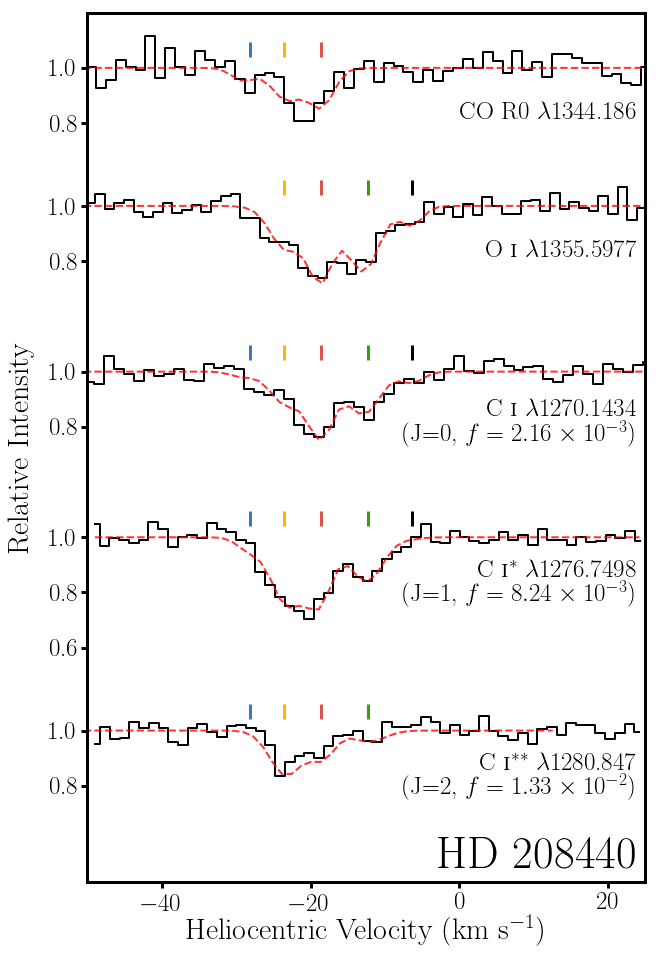

In [3]:
import matplotlib.pyplot as plt
plt.style.use('sm')

import seaborn as sb
blue,amber,red,green=sb.xkcd_palette(['windows blue','amber','pale red','grass green'])
import os
%matplotlib inline
c=300000.

sl='HD208440'
c1_offset=1.3
o_offset=1.9
co_offset=2.4
to_plot=[(1270.1434,'C~\\textsc{i} $\lambda$1270.1434\n(J=0, $f=2.16\\times10^{-3}$)',c1_offset), 
         (1355.5977,'O~\\textsc{i} $\lambda$1355.5977',o_offset),
         (1344.186,'CO R0 $\lambda$1344.186',co_offset)
        ]


fig=plt.figure(figsize=(10,16),facecolor='w')
subplt=plt.subplot(111)

for rest_wav,text,offset in to_plot:
    dat_file=top_path+'x1d_files/'+sl+'/E140H/{:}_{:}.dat'.format(sl,rest_wav)
    theor_profile=top_path+'x1d_files/'+sl+'/E140H/'+'{:}_profile.fits'.format(rest_wav)
    #txt_file=[i for i in os.listdir(top_path+'x1d_files/'+sl+'/E140H/') if i.endswith('txt') and str(int(rest_wav)) in i][0]
    #ions=parse_results_file(top_path+'x1d_files/'+sl+'/E140H/'+txt_file)

    wavs,flxs=[],[]
    with open(dat_file,'r') as myfile:
        for line in myfile:
            if len(line.split())==2:
                wav,flx=map(float,line.split())
            else:
                wav,flx,err=map(float,line.split())
            wavs.append(wav)
            flxs.append(flx)
    wavs=np.array(wavs)
    flxs=np.array(flxs)
    vels=c*(wavs-rest_wav)/rest_wav
    
    
    hdulist=fits.open(theor_profile,do_not_scale_image_data=True)
    refval=hdulist[0].header['CRVAL1']
    delta=hdulist[0].header['CDELT1']
    fit=hdulist[0].data.byteswap()/10000.
    ref_idx=np.abs(vels-refval).argmin()
    fit_vels=vels[ref_idx:ref_idx+len(fit)]
    
    subplt.step(vels,flxs+offset,color='k',where='mid',lw=2)
    subplt.plot(fit_vels,fit+offset,'r--',lw=2,alpha=0.8)
    fs=25
    bl=0.88
    if offset==0:
        fs=25
        bl=0.4
    #    subplt.text(105,0.80,'C~\\textsc{i}',fontsize=25,va='top',ha='left')
    #    subplt.text(105,0.70,'$\lambda$1280.1353',fontsize=25,va='top',ha='left')
    #else:
    #    subplt.text(160,0.90+offset,text,fontsize=25,va='top',ha='right')
    subplt.text(24,bl+offset,text,fontsize=fs,va='top',ha='right')
    
    
    
    
offset=0.7
rest_wav=1276.7498#1279.8904 # <-- use 1280.1353 files
dat_file=top_path+'x1d_files/'+sl+'/E140H/HD208440_1276.7498.dat'
theor_profile=top_path+'x1d_files/'+sl+'/E140H/1276.7498_profile.fits'
wavs,flxs=[],[]
with open(dat_file,'r') as myfile:
    for line in myfile:
        if len(line.split())==2:
            wav,flx=map(float,line.split())
        else:
            wav,flx,err=map(float,line.split())
        wavs.append(wav)
        flxs.append(flx)
wavs=np.array(wavs)
flxs=np.array(flxs)
vels=c*(wavs-rest_wav)/rest_wav
subplt.step(vels[np.where((vels>-50) & (vels<25))],flxs[np.where((vels>-50) & (vels<25))]+offset,color='k',where='mid',lw=2)

hdulist=fits.open(theor_profile,do_not_scale_image_data=True,ignore_missing_end=True)
refval=hdulist[0].header['CRVAL1']
delta=hdulist[0].header['CDELT1']
fit=hdulist[0].data.byteswap()/10000.
ref_idx=np.abs(vels-refval).argmin()
fit_vels=vels[ref_idx:ref_idx+len(fit)]#-(c*(1279.8904-1280.1353)/1279.8904)
subplt.plot(fit_vels[np.where((fit_vels>-50) & (fit_vels<25))],fit[np.where((fit_vels>-50) & (fit_vels<25))]+offset,'r--',lw=2,alpha=0.8)

subplt.text(24,0.9+offset,'C~\\textsc{i}$^*$ $\lambda$1276.7498\n(J=1, $f=8.24\\times10^{-3}$)',
            fontsize=fs,va='top',ha='right')





offset=0.0
rest_wav=1280.8470
dat_file=top_path+'x1d_files/'+sl+'/E140H/HD208440_1280.1353.dat'
theor_profile=top_path+'x1d_files/'+sl+'/E140H/1280.1353_profile.fits'
wavs,flxs=[],[]
with open(dat_file,'r') as myfile:
    for line in myfile:
        if len(line.split())==2:
            wav,flx=map(float,line.split())
        else:
            wav,flx,err=map(float,line.split())
        wavs.append(wav)
        flxs.append(flx)
wavs=np.array(wavs)
flxs=np.array(flxs)
vels=c*(wavs-rest_wav)/rest_wav
subplt.step(vels[np.where((vels>-50) & (vels<25))],flxs[np.where((vels>-50) & (vels<25))]+offset,color='k',where='mid',lw=2)

hdulist=fits.open(theor_profile,do_not_scale_image_data=True,ignore_missing_end=True)
refval=hdulist[0].header['CRVAL1']
delta=hdulist[0].header['CDELT1']
fit=hdulist[0].data.byteswap()/10000.
ref_idx=np.abs(vels-refval).argmin()
fit_vels=vels[-100:]-(c*(1280.847-1280.1353)/1280.847)
subplt.plot(fit_vels+51,fit[-100:]+offset,'r--',lw=2,alpha=0.8)

subplt.text(24,0.9,'C~\\textsc{i}$^{**}$ $\lambda$1280.847\n(J=2, $f=1.33\\times10^{-2}$)',
            fontsize=fs,va='top',ha='right')



        

    
subplt.tick_params(axis='both',which='major',labelsize=25)
subplt.set_xlabel('Heliocentric Velocity (km s$^{-1}$)',fontsize=30)
subplt.set_ylabel('Relative Intensity',fontsize=30,labelpad=15)

subplt.text(24,0.5,'HD~208440',fontsize=45,va='bottom',ha='right')

cols=(blue,amber,red,green,'k')

vs=(-28.1,-23.5,-18.6,-12.3,-6.4)
for v in vs[0:3]:
    subplt.plot(v,1.07+co_offset,marker='|',color=cols[vs.index(v)],ms=15,mew=3)

for v in vs[1:]:
    subplt.plot(v,1.07+o_offset,marker='|',color=cols[vs.index(v)],ms=15,mew=3)

for v in vs:
    subplt.plot(v,1.07+0.7,marker='|',color=cols[vs.index(v)],ms=15,mew=3)
    subplt.plot(v,1.07+1.3,marker='|',color=cols[vs.index(v)],ms=15,mew=3)

for v in vs[:-1]:
    subplt.plot(v,1.07,marker='|',color=cols[vs.index(v)],ms=15,mew=3)


            
subplt.set_xlim(-50,25)
subplt.set_ylim(0.45,3.6)
subplt.set_yticks([0.8,1.0,1.3,1.5,1.7,2.1,2.3,2.7,2.9,3.2,3.4])
subplt.set_yticklabels([0.8,1.0,0.6,0.8,1.0,0.8,1.0,0.8,1.0,0.8,1.0])

#plt.savefig(output_path+'HD208440_spectra.pdf',bbox_inches='tight')

In [ ]:
# Vertical versions of the above 2 plots
import matplotlib.pyplot as plt
plt.style.use('sm')
import os
%matplotlib inline
c=300000.


sl='HD62542'

to_plot=[(1274.1090,'C~\\textsc{i}$^{**}$ $\lambda$1274.109\n(J=2, $f=5.62\\times10^{-4}$)',0.0),
         (1287.6076,'C~\\textsc{i}$^*$ $\lambda$1287.6076\n(J=1, $f=6.03\\times10^{-5}$)',0.7),
         (1270.1434,'C~\\textsc{i} $\lambda$1270.1434\n(J=0, $f=2.16\\times10^{-3}$)',1.6),
         (1355.5977,'O~\\textsc{i} $\lambda$1355.5977',2.4)
         #(1263.433,'CO $\lambda$1263.433',co_offset)
        ]


fig=plt.figure(figsize=(10,16),facecolor='w')
subplt=plt.subplot(111)

for rest_wav,text,offset in to_plot:
    dat_file=top_path+'x1d_files/'+sl+'/E140H/{:}_{:}.dat'.format(sl,rest_wav)
    theor_profile=top_path+'x1d_files/'+sl+'/E140H/'+'{:}_profile.fits'.format(rest_wav)

    wavs,flxs=[],[]
    with open(dat_file,'r') as myfile:
        for line in myfile:
            if len(line.split())==2:
                wav,flx=map(float,line.split())
            else:
                wav,flx,err=map(float,line.split())
            wavs.append(wav)
            flxs.append(flx)
    wavs=np.array(wavs)
    flxs=np.array(flxs)
    vels=c*(wavs-rest_wav)/rest_wav

    
    
    hdulist=fits.open(theor_profile,do_not_scale_image_data=True,ignore_missing_end=True)
    refval=hdulist[0].header['CRVAL1']
    delta=hdulist[0].header['CDELT1']
    fit=hdulist[0].data.byteswap()/10000.
    ref_idx=np.abs(vels-refval).argmin()
    fit_vels=vels[ref_idx:ref_idx+len(fit)]
    
    shift=0
    if rest_wav==1270.1434:
        shift=-0.7
    elif rest_wav==1287.6076:
        shift=-0.3
    elif rest_wav==1274.109:
        shift=-0.5
    subplt.step(vels+shift,flxs+offset,color='k',where='mid',lw=2)
    subplt.plot(fit_vels+shift,fit+offset,'r--',lw=2,alpha=0.8)
    subplt.text(44,0.90+offset,text,fontsize=25,va='top',ha='right')
    #subplt.step(fit_vels,residuals+1.2,color='k',where='mid',lw=1)
       
offset=3.3
rest_wav=1246.059
dat_file=top_path+'x1d_files/'+sl+'/E140H/HD62542_1246.059.dat'
theor_profile=top_path+'x1d_files/'+sl+'/E140H/1246.059_profile.fits'
wavs,flxs=[],[]
with open(dat_file,'r') as myfile:
    for line in myfile:
        if len(line.split())==2:
            wav,flx=map(float,line.split())
        else:
            wav,flx,err=map(float,line.split())
        wavs.append(wav)
        flxs.append(flx)
wavs=np.array(wavs)
flxs=np.array(flxs)
vels=c*(wavs-rest_wav)/rest_wav
#idxs=np.where((vels>4)&(vels<19))
subplt.step(vels,flxs+offset,color='k',where='mid',lw=2)

hdulist=fits.open(theor_profile,do_not_scale_image_data=True,ignore_missing_end=True)
refval=hdulist[0].header['CRVAL1']
delta=hdulist[0].header['CDELT1']
fit=hdulist[0].data.byteswap()/10000.
ref_idx=np.abs(vels-refval).argmin()
fit_vels=vels[ref_idx:ref_idx+len(fit)]
#idxs=np.where((fit_vels>4)&(fit_vels<19))
subplt.plot(fit_vels,fit+offset,'r--',lw=2,alpha=0.8)
#subplt.plot(np.append(np.append([1],fit_vels[idxs]),[25]),np.append(np.append([2.8],fit[idxs]+offset),[2.8]),'r--',lw=2,alpha=0.8)
subplt.text(44,0.7+offset,'CO $\lambda$1246.059',fontsize=25,va='top',ha='right')


subplt.set_xlabel('Heliocentric Velocity (km s$^{-1}$)',fontsize=30,labelpad=15)
subplt.set_ylabel('Relative Intensity',fontsize=30,labelpad=15)

subplt.text(44,0.3,'HD~62542',fontsize=45,va='bottom',ha='right')

subplt.set_xlim(3,45)
subplt.set_ylim(0.25,4.7)
subplt.tick_params(axis='both',which='major',labelsize=25)


for offset in (0.0,0.6,1.6,2.4):
    subplt.plot(13.85,1.05+offset,'k|',ms=15,mew=3)
    
co_lines=((1246.059,'R0'),
          (1246.036,'R1'),
          (1246.119,'Q1'),
          (1246.033,'R2'),
          (1246.156,'Q2'),
          #(1246.238,'P2'),
          (1246.049,'R3')
          #(1246.212,'Q3'),
          #(1246.335,'P3')
         )
for line,text in co_lines:
    vel=13.85+c*((line-1246.059)/1246.059)
    subplt.plot(vel,4.4,'k|',ms=15,mew=3)
    if text=='R1':
        vel=vel+1
    elif text=='R2':
        vel=vel-0.7
    subplt.text(vel,4.44,text,fontsize=20,rotation=45,ha='center',va='bottom')

    
subplt.set_yticks([0.4,0.6,0.8,1.0,1.3,1.5,1.7,2.0,2.2,2.4,2.6,3.0,3.2,3.4,3.9,4.1,4.3])
subplt.set_yticklabels([0.4,0.6,0.8,1.0,0.6,0.8,1.0,0.4,0.6,0.8,1.0,0.6,0.8,1.0,0.6,0.8,1.0])

#plt.savefig(output_path+'HD62542_spectra.pdf',bbox_inches='tight')

In [ ]:
for sl in primary_sightlines:
    co_results=[i for i in os.listdir(top_path+'x1d_files/'+sl+'/E140H/') if i.startswith('co') and i.endswith('_results.txt')]
    co_results.sort(key=lambda x: int(x.split('_')[1]))
    print(sl,co_results[0])
    with open(top_path+'x1d_files/'+sl+'/E140H/'+co_results[0],'r') as myfile:
        for line in myfile:
            if line.strip().startswith('CO'):
                print(line.strip()[0:50])
            
    print()
    print()

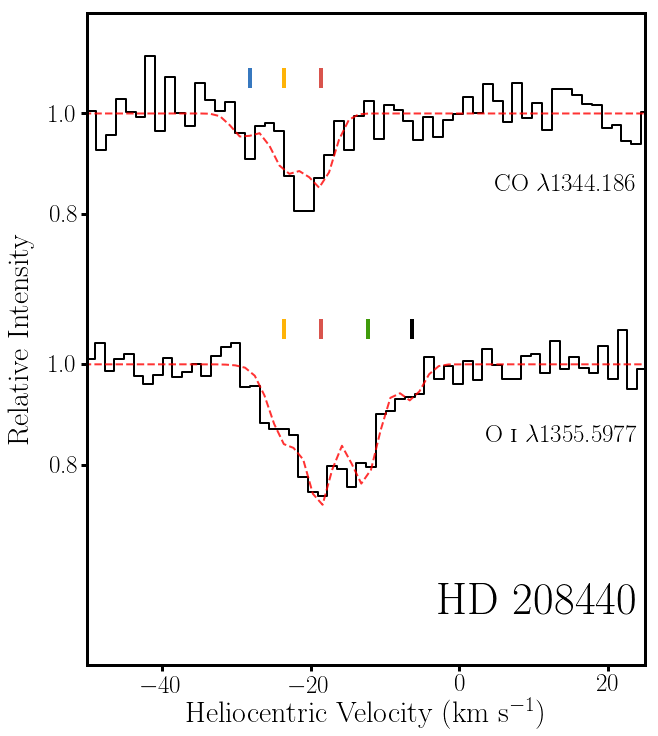

In [20]:
import matplotlib.pyplot as plt
plt.style.use('sm')

import seaborn as sb
blue,amber,red,green=sb.xkcd_palette(['windows blue','amber','pale red','grass green'])
import os
%matplotlib inline
c=300000.

sl='HD208440'
c1_offset=1.3
o_offset=1.9
co_offset=2.4
to_plot=[(1355.5977,'O~\\textsc{i} $\lambda$1355.5977',o_offset),
         (1344.186,'CO $\lambda$1344.186',co_offset)
        ]


fig=plt.figure(figsize=(10,12),facecolor='w')
subplt=plt.subplot(111)

for rest_wav,text,offset in to_plot:
    dat_file=top_path+'x1d_files/'+sl+'/E140H/{:}_{:}.dat'.format(sl,rest_wav)
    theor_profile=top_path+'x1d_files/'+sl+'/E140H/'+'{:}_profile.fits'.format(rest_wav)
    #txt_file=[i for i in os.listdir(top_path+'x1d_files/'+sl+'/E140H/') if i.endswith('txt') and str(int(rest_wav)) in i][0]
    #ions=parse_results_file(top_path+'x1d_files/'+sl+'/E140H/'+txt_file)

    wavs,flxs=[],[]
    with open(dat_file,'r') as myfile:
        for line in myfile:
            if len(line.split())==2:
                wav,flx=map(float,line.split())
            else:
                wav,flx,err=map(float,line.split())
            wavs.append(wav)
            flxs.append(flx)
    wavs=np.array(wavs)
    flxs=np.array(flxs)
    vels=c*(wavs-rest_wav)/rest_wav
    
    
    hdulist=fits.open(theor_profile,do_not_scale_image_data=True)
    refval=hdulist[0].header['CRVAL1']
    delta=hdulist[0].header['CDELT1']
    fit=hdulist[0].data.byteswap()/10000.
    ref_idx=np.abs(vels-refval).argmin()
    fit_vels=vels[ref_idx:ref_idx+len(fit)]
    
    subplt.step(vels,flxs+offset,color='k',where='mid',lw=2)
    subplt.plot(fit_vels,fit+offset,'r--',lw=2,alpha=0.8)
    fs=25
    bl=0.88
    if offset==0:
        fs=25
        bl=0.4
    subplt.text(24,bl+offset,text,fontsize=fs,va='top',ha='right')
    

    
subplt.tick_params(axis='both',which='major',labelsize=25)
subplt.set_xlabel('Heliocentric Velocity (km s$^{-1}$)',fontsize=30)
subplt.set_ylabel('Relative Intensity',fontsize=30,labelpad=15)

subplt.text(24,2.4,'HD~208440',fontsize=45,va='bottom',ha='right')

cols=(blue,amber,red,green,'k')

vs=(-28.1,-23.5,-18.6,-12.3,-6.4)
for v in vs[0:3]:
    subplt.plot(v,1.07+co_offset,marker='|',color=cols[vs.index(v)],ms=20,mew=4)

for v in vs[1:]:
    subplt.plot(v,1.07+o_offset,marker='|',color=cols[vs.index(v)],ms=20,mew=4)


            
subplt.set_xlim(-50,25)
subplt.set_ylim(2.3,3.6)
subplt.set_yticks([2.7,2.9,3.2,3.4])
subplt.set_yticklabels([0.8,1.0,0.8,1.0])

plt.savefig('/Users/codydirks/Desktop/HD208440_spectra.pdf',bbox_inches='tight')

